# Описание проекта
Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. В рамках проекта требуется: 
- Изучить воронку продаж, узнать, 
    - как пользователи доходят до покупки, 
    - сколько пользователей доходит до покупки, а сколько - застревает на предыдущих шагах 
    - на каких именно шагах застревают пользователи 
- Исследовать результаты A/A/B эксперимента по смене шрифтов во всём приложении, выяснить, какой шрифт лучше. 

Для анализа доступны следующие данные: 
- Файл с логами `/datasets/logs_exp.csv`, где 
    - `EventName` - название события;
    - `DeviceIDHash` — уникальный идентификатор пользователя;
    - `EventTimestamp` — время события;
    - `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Шаг 1. Загрузка данных 
Загрузим файл с логами для дальнейшего анализа. 

In [1]:
# Отдельно наверх вынесен импорт библиотек, набор импортируемых библиотек расширяется по ходу проекта. 
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import math
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats 

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv')
display(data.head())

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


In [3]:
# видим, что данные разделены сепаратором \t, считаем этот формат 
data = pd.read_csv('/datasets/logs_exp.csv',sep='\t')
display(data.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# сразу верхнеуровнево посмотрим информацию о датасете 
display(data.describe())
display(data.info())

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

## Вывод по шагу 1
Загрузили данные, обработав используемый в датасете сепаратор. 

В датасете 244126 записей. Можно переходить к предобработке данных. 

# Шаг 2. Предобработка данных 
В рамках предобработки данных для дальнейшего анализа сделаем следующее: 
- заменим названия столбцов на более удобные, с snake_case 
- проверим данные на наличие явных дубликатов и избавимся от них, если такие есть 
- выделим дату и время в отдельный столбец 

In [5]:
# переименовываем столбцы 
data.columns = ['event_name', 'device_id', 'event_time', 'exp_id']
display(data.head())

,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# количество дубликатов в датасете
print('Количество явных дубликатов в датасете: ', data.duplicated().sum())


Количество явных дубликатов в датасете:  413


In [7]:
# удаляем дубликаты 
data = data.drop_duplicates().reset_index(drop=True)
print('Количество явных дубликатов в датасете после удаления: ', data.duplicated().sum())

Количество явных дубликатов в датасете после удаления:  0


In [8]:
# теперь проверим количество пропусков 
print('Количество пропусков: ')
data.isna().sum()

Количество пропусков: 


event_name    0
device_id     0
event_time    0
exp_id        0
dtype: int64

In [9]:
# нужно добавить столбец даты и времени и отдельный столбец дат
# вместо добавления нового столбца просто поменяем тип данных в столбце event_time
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['date']=data['event_time'].dt.strftime('%Y-%m-%d')
data['date'] = pd.to_datetime(data['date'])
display(data.head())
data.info()

,event_name,device_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   exp_id      243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


## Вывод по шагу 2
Удалили 413 явных дубликата из датасета, переименовали столбцы в удобный для работы snake_case. Проверили, что в датасете нет пропусков. Отформатировали столбец с датой и временем, вывели дату в отдельный столбец для удобства дальнейшего анализа. На этом подготовку можно считать сделанной, можно приступать к изучению данных. 

# Шаг 3. Изучение и проверка данных
На этом шаге изучим и очистим данные, ответив на вопросы: 
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? 
- Найдём максимальную и минимальную дату. 
- Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Узнаем, можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. 
- Данными за какой период времени мы располагаем на самом деле?
- Много ли событий и пользователей мы потеряем, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [10]:
# Количество событий в логе = количеству записей после удаления явных дубликатов 
print('Количество событий в логе: ', len(data))

Количество событий в логе:  243713


In [11]:
# Под пользователями в логе понимается device id, посчитаем их количество 
print('Количество пользователей, фигурирующих в логе:', len(data['device_id'].unique()))

Количество пользователей, фигурирующих в логе: 7551


In [12]:
# среднее количество событий на пользователя - посмотрим медиану, среднее и перцентили 
data['device_id'].value_counts().describe()


count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: device_id, dtype: float64

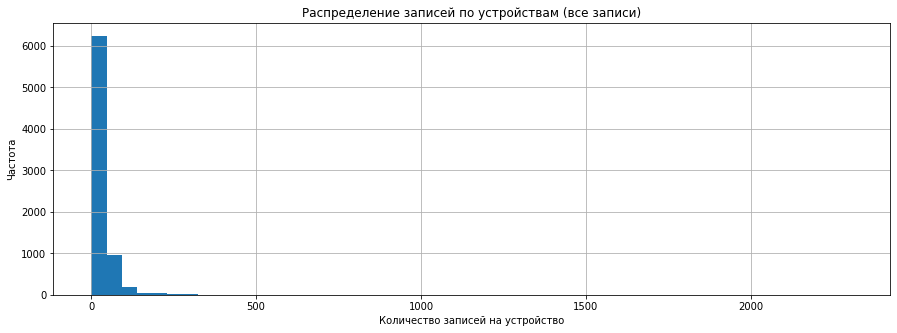

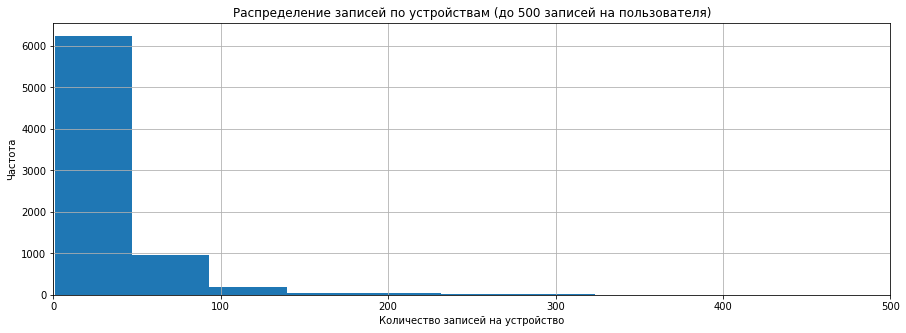

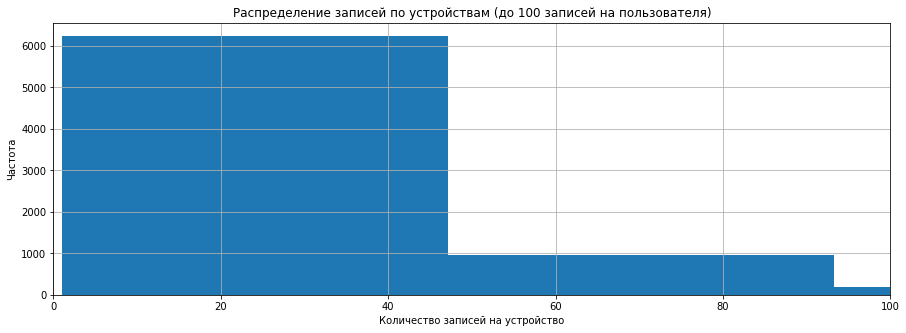

In [13]:
# визуализируем  и масштабируем 
plt.figure(figsize=(15, 5))
data['device_id'].value_counts().hist(bins=50)
plt.title('Распределение записей по устройствам (все записи)')
plt.xlabel('Количество записей на устройство')
plt.ylabel('Частота')
plt.show()

# Визуализация с ограничением по оси X
plt.figure(figsize=(15, 5))
data['device_id'].value_counts().hist(bins=50)
plt.xlim(0, 500)  # Ограничиваем диапазон по X
plt.title('Распределение записей по устройствам (до 500 записей на пользователя)')
plt.xlabel('Количество записей на устройство')
plt.ylabel('Частота')
plt.show()


plt.figure(figsize=(15, 5))
data['device_id'].value_counts().hist(bins=50)
plt.xlim(0, 100)  # Ограничиваем диапазон по X
plt.title('Распределение записей по устройствам (до 100 записей на пользователя)')
plt.xlabel('Количество записей на устройство')
plt.ylabel('Частота')
plt.show()



Получили среднее значение количества записей в логе на пользователя - 32. 
Для 50% пользователей в логе есть по 20 записей, максимальное значение - 2307 записей. 
Далее оценим, данными за какой срок мы располагаем 

In [14]:
print('Данные в датасете - от', data['date'].min(), 'до', data['date'].max())

Данные в датасете - от 2019-07-25 00:00:00 до 2019-08-07 00:00:00


Итак, мы располагаем данными за период от 25 июля 2019 до 7 августа 2019 года. Визуализируем график и посмотрим, сколько событий у нас есть по дням. 

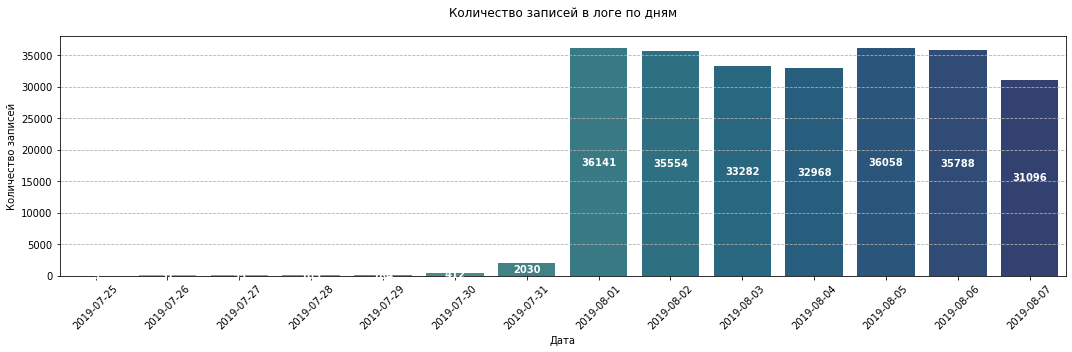

In [15]:
# Визуализируем 
# Группируем данные по дате и считаем количество записей
daily_records = data.groupby('date')['event_name'].count().reset_index(name='records_count')
# Сортируем по дате 
daily_records = daily_records.sort_values('date')
# уберём время 
daily_records['date'] = daily_records['date'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(15, 5))
ax = sns.barplot(x='date', y='records_count', data=daily_records, 
                palette='crest', saturation=0.8)

# Добавляем подписи внутри столбцов, чтобы было нагляднее
for i, v in enumerate(daily_records['records_count']):
    ax.text(i, v/2, str(v),
            ha='center', va='center', 
            color='white', fontweight='bold')

plt.title('Количество записей в логе по дням', pad=20)
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()


Видим, что до 1 августа сообщений в логах относительно мало. Мы имеем дело с логами, поэтому такой рост может быть вызван не только ростом активности пользователей с 1 августа, но и тем, чтов системе, например, могли включить нужный уровень логирования. В любом случае, корректно будет взять данные по дням, в которые было сравнительно одинаковое количество событий. Поэтому ограничимся данными за 01.08-07.08. 

In [16]:
# не будем перезаписывать имеющийся датасет, запишем в новую переменную отфильтрованные данные 
start_date = pd.to_datetime('2019-08-01')
data_filtered = data.query(f"date >= '{start_date}'")  
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   exp_id      240887 non-null  int64         
 4   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


После фильтрации из 244126 осталось 240887 записей в датасете, т.е. мы отфильтровали небольшой процент. Посчитаем, какой именно процент отфильтровали

In [17]:
users = data['device_id'].nunique()
users_filtered = data_filtered['device_id'].nunique()
print('Количество данных в логе до фильтрации:                   ', len(data))
print('Количество данных в логе после фильтрации:                ', len(data_filtered))
print('Количество уникальных пользователей до фильтрации:        ', users)
print('Количество уникальных пользователей после фильтрации:     ', users_filtered)
print('Убрано пользователей после фильтрации:                    ', (users - users_filtered))
print('Процент пользователей, данные по которым отбрасываем:     ', (100*(users - users_filtered)/users))
print('Среднее количество событий на пользователя до фильтрации: ', len(data['device_id'])/users)
print('Среднее количество событий на пользователя до фильтрации: ', len(data_filtered['device_id'])/users_filtered)

Количество данных в логе до фильтрации:                    243713
Количество данных в логе после фильтрации:                 240887
Количество уникальных пользователей до фильтрации:         7551
Количество уникальных пользователей после фильтрации:      7534
Убрано пользователей после фильтрации:                     17
Процент пользователей, данные по которым отбрасываем:      0.22513574361011787
Среднее количество событий на пользователя до фильтрации:  32.27559263673685
Среднее количество событий на пользователя до фильтрации:  31.97332094504911


Получается, мы удалим данные всего по 17 пользователям, избавившись от данных до 1 августа, и это 0.23 процента от всей массы пользователей. Среднее количество событий на пользователя при этом не поменяется, это 32 - объяснимо, объём данных, которые мы отбрасываем, несравнимо мал. 



Для завершения шага осталось проверить, что у нас есть пользователи из всех трёх групп. Принадлежность к группе мы можем проверить по полю exp_id

In [18]:

display(data_filtered.groupby('exp_id').agg({'device_id': 'nunique'}))

,device_id
exp_id,
246,2484
247,2513
248,2537


Данные по всем трём группам есть, и их примерно одинаковое количество. 
## Вывод по шагу 3
Изучили данные, узнали, что 
- изначально в логе было 243713 записи;
- в записях фигурирует информация по 7551 уникальному пользователю;
- в среднем на пользователя приходится 32 записи в логе; 
- в логе представлены данные за период 25.07-07.08.2019.
Отбросили данные до 01.08, поскольку их несравнимо мало, и они могут повлиять на корректность результатов анализа. 
После фильтрации мы отбросили данные по 17 пользователям, это 0.22 процента от общей массы. Кроме того, фильтрация данных не оказала существенного влияния на количество записей на каждого пользователя. 
Также в рамках шага проверили, что мы располагаем данными из всех трёх экспериментальных групп, и количество пользователей в группах примерно одинаково. 

Дальше будем работать с отфильтрованными данными. 



# Шаг 4. Изучение воронки событий

В рамках шага нам предстоит: 
- Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.
- Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. 
- Посчитать долю пользователей, которые хоть раз совершали событие.
- Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- Узнать, на каком шаге мы теряем больше всего пользователей. 
- Выяснить, какая доля пользователей доходит от первого события до оплаты. 





In [19]:
# выведем сгруппированные по имени события, отсортируем их по частоте фигурирования в логах
display(data_filtered
        .groupby('event_name')['device_id']
        .count()
        .sort_values(ascending=False))


event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id, dtype: int64

Самое частое событие - MainScreenAppear, затем идут OffersScreenAppear и CartsScreenAppear, затем PaymentScreentSuccessful, и наименее часто встречающееся событие по логам - Tutorial. Описание событий не приложено к данным, но похоже, что 
- ```MainScreenAppear``` - это появление главного экрана
- `OffersScreenAppear` - появление экрана с предложениями
- `CartScreenAppear` - экран корзины
- `PaymentScreenSuccessful` - успешная оплата
- `Tutorial` - мануал по использованию приложения


In [20]:
# Количество пользователей, совершивших каждое событие - группируем данные, сортируем по убыванию 
users_count = (data_filtered
               .groupby('event_name')['device_id']
               .nunique()
               .sort_values(ascending=False)
               .reset_index()
               .rename(columns={'device_id': 'total_users'})
              )
# добавим процент 
users_count['percent'] = (users_count['total_users'] / data['device_id'].nunique() * 100).round(2)
display(users_count)

,event_name,total_users,percent
0,MainScreenAppear,7419,98.25
1,OffersScreenAppear,4593,60.83
2,CartScreenAppear,3734,49.45
3,PaymentScreenSuccessful,3539,46.87
4,Tutorial,840,11.12


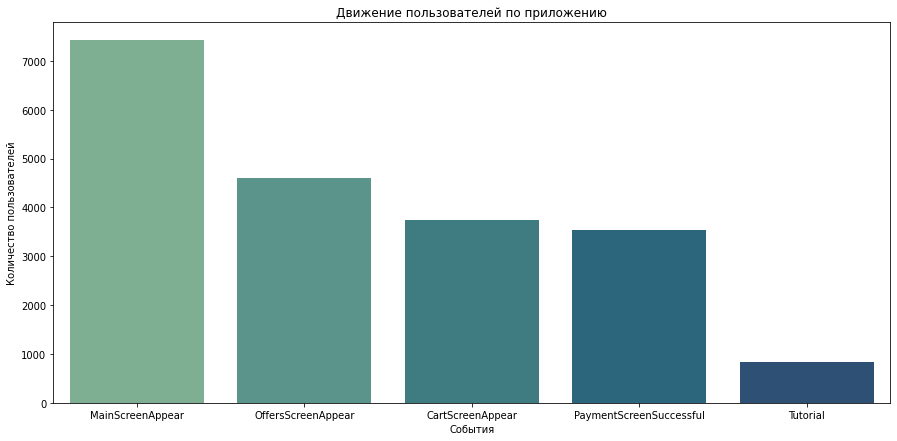

In [21]:
# визуализируем столбчатой диаграммой
plt.figure(figsize=(15, 7))
sns.barplot(data=users_count.loc[0:4], x='event_name', y='total_users', palette='crest')
plt.title('Движение пользователей по приложению')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show()

Судя по всему, воронка выстраивается следующим образом: 
`MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful` 

Экран `Tutorial` - мануал по использованию приложения - скорее всего, необязательный и может быть вызван из любого шага, он не входит в последовательную цепочку действий пользователя. Его мы можем исключить из дальнейшей работы. 

In [22]:
# посчитаем долю пользователей, которые хоть раз совершали событие - для каждого события в логе
number_of_events_by_users = (
    data_filtered
    .groupby('event_name')
    .agg({'device_id': 'nunique'})
    .sort_values(by='device_id', ascending=False)
    .reset_index()
)
number_of_events_by_users['percent'] = round(
    100 * number_of_events_by_users['device_id']
    / data_filtered['device_id']
    .nunique(), 2
)
display(number_of_events_by_users)

,event_name,device_id,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Видим, что до первого шага дошло 98.47 процента пользователей, - это может быть обусловлено тем, что мы взяли логи за конкретные даты, и часть логов - это пользовательские пути, которые начались раньше, чем начался период, за который мы берём срез. Эта часть незначительна, чуть больше полутора процентов, поэтому можем продолжать работать с данными. 
До второго шага дошло почти 61% пользователей, далее - 49.56 и 46.97 процентов на 3 и 4 шаги соответственно. 

In [23]:
# теперь посчитаем, какая доля пользователей переходит на следующий шаг - для каждого шага воронки 
# для простоты расчётов добавим столбец с количеством пользователей на предыдущем шаге, сделаем это с помощью shift 
# отрежем столбец с экраном tutorial, поскольку он не вписывается в последовательность
# Создаем копию DataFrame явно
users_events = users_count.query('event_name != "Tutorial"').copy()

display(users_events)

users_events['total_users_int'] = users_events['total_users']
users_events['total_users_int'] = users_events['total_users_int'].shift(periods=1)

# Добавляем в таблицу столбец с долей пользователей, проходящих на каждый следующий шаг воронки
users_events['users_next_step'] = (((users_events['total_users']/users_events['total_users_int']).round(2))
                                      .apply(lambda x: f"{x:1.1%}"))

display(users_events)

,event_name,total_users,percent
0,MainScreenAppear,7419,98.25
1,OffersScreenAppear,4593,60.83
2,CartScreenAppear,3734,49.45
3,PaymentScreenSuccessful,3539,46.87


,event_name,total_users,percent,total_users_int,users_next_step
0,MainScreenAppear,7419,98.25,NaN,nan%
1,OffersScreenAppear,4593,60.83,7419.0,62.0%
2,CartScreenAppear,3734,49.45,4593.0,81.0%
3,PaymentScreenSuccessful,3539,46.87,3734.0,95.0%


Итого, с главного экрана перешло 62% пользователей, далее к корзине перешёл 81% пользователей, и после захода в корзину к оплате перешло 95% пользователей с предыдущего шага. 
Здесь легко посчитать, что на первом шаге мы теряем больше всего пользователей - 48%, на переходе к корзине потеряли 19 % пользователей, а на шаге от корзины к оплате переходят почти все, теряется только 5% пользователей. 



Но мы можем визуализировать воронку для наглядности: 

In [24]:
# посчитаем, на каком шаге теряется больше всего пользователей 
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)  # для Jupyter Notebook
# Строим воронку
fig = go.Figure(go.Funnel(
    y = users_events['event_name'].to_list(),
    x = users_events['total_users'].to_list() ,
    textposition = "inside",
    textinfo = "value+percent previous+percent initial",
    )) 
fig.update_layout(title_text='Воронка событий', titlefont_size=18)
fig.update_layout(yaxis_title = 'События', titlefont_size=18)
fig.show()

По графику видим, что до оплаты доходит 48% пользователей, это 3539. 

## Вывод по шагу 4

- изучили события в логах, отсортировали их по частоте. 
- выявили, какой процент пользователей дошёл до каждого конкретного шага 
- построили последовательную цепочку событий, - `MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful` 
- посчитали, какой процент пользователей дошёл до каждого шага воронки. 
- изучили по воронке событий, сколько пользователей дошло до каждого конкретного шага 
- узнали, что теряем больше всего пользователей на шаге OffersScreenAppear - до него доходит 62% пользователей с предыдущего шага. А меньше всех пользователей "теряется" между корзиной и оплатой. 
- узнали, что до оплаты доходит 48% пользователей. 

Перейдём к анализу результатов эксперимента 

# Шаг 5. Изучение результатов эксперимента 
В рамках анализа изучим: 
- сколько пользователей попало в каждую экспериментальную группу 
- находят ли статистические критерии разницу между выборками 246 и 247
- для групп 246 и 247 для каждого события посчитаем число и долю пользователей в каждой группе, совершивших это событие. Изучим различие между группами по этим числам, поймём, будет ли разница статистически достоверной 
- проведём то же самое для группы B 
- посчитаем, сколько проверок статистических гипотез мы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. уточним, какой уровень значимости стоит применить. 

In [25]:
# для начала сделаем отдельный датафрейм без события Tutorial. Работаем с данными, которые уже отфильтровали по датам 
data_filtered_main = data_filtered[data_filtered['event_name'] != 'Tutorial']
display(data_filtered_main)
data_filtered_main.info()

,event_name,device_id,event_time,exp_id,date
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 239882 entries, 2827 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  239882 non-null  object        
 1   device_id   239882 non-null  int64         
 2   event_time  239882 non-null  datetime64[ns]
 3   exp_id      239882 non-null  int64         
 4   date        239882 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [26]:
# Выводим количество пользователей в каждой из групп
users_by_group =   (data_filtered_main
    .groupby('exp_id')
    .agg({'device_id': 'nunique'})
    .reset_index()
    .rename(columns={'device_id':'number_of_users'})
)
display(users_by_group)

,exp_id,number_of_users
0,246,2483
1,247,2512
2,248,2535


Получили примерно равное количество пользователей в каждой из групп. 

Проверим, попали ли какие-то пользователи сразу в несколько групп 

In [27]:
# посчитаем количество групп для каждого device_id и выведем, у каких пользователей оказалось больше одной группы 
count_groups = data_filtered_main.groupby('device_id')['exp_id'].nunique()
data_by_group = data_filtered_main.merge(count_groups, on=['device_id', 'device_id'])
data_by_group.columns = ['event_name', 'device_id', 'event_time', 'exp_id', 'date', 'nunique_exp_id']
#display(data_by_group)
data_by_group_double = data_by_group[data_by_group['nunique_exp_id'] != 1]
print('Количество пользователей, попавших в несколько групп теста: ', len(data_by_group_double))
display(data_by_group.head())

Количество пользователей, попавших в несколько групп теста:  0


,event_name,device_id,event_time,exp_id,date,nunique_exp_id
0,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,1
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,1
2,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,1
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01,1
4,MainScreenAppear,3737462046622621720,2019-08-01 00:10:47,246,2019-08-01,1


Получается, каждый пользователь фигурирует только в одной группе. 


Далее для групп A/A проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [28]:
# разбиваем таблицу по группам, чтобы посмотреть количество пользователей по каждому событию 
#users_by_events = data_filtered_main.pivot_table(index='exp_id',columns='event_name', values='device_id', aggfunc='nunique').reset_index()
users_by_events = data_filtered.pivot_table(index='exp_id',columns='event_name', values='device_id', aggfunc='nunique').reset_index()

display(users_by_events)
#display(data_filtered.head())
# добавляем столбец с общим количеством пользователей в группе - для этого возьмём ранее созданную таблицу users_by_group
users_by_events['number_of_users'] = users_by_group['number_of_users']
display(users_by_events)

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,number_of_users
0,246,1266,2450,1542,1200,278,2483
1,247,1238,2476,1520,1158,283,2512
2,248,1230,2493,1531,1181,279,2535


Сравним группы 246 и 247. 

In [29]:
# сразу заведём функцию для вывода результатов теста 
def test_result(value_1, value_2):
    if value_1 < value_2:
        print('Отвергаем нулевую гипотезу: разница значимая. P_value:', value_1)
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать разницу значимой. P_value:', value_1)

# заведём функцию для проверки 
def hypo_test (trials_1, trials_2, successes_1, successes_2):
    
    # пропорция успехов в первой группе
    p1 = successes_1/trials_1   
    # пропорция успехов во второй группе
    p2 = successes_2/trials_2
    # пропорция успехов в комбинированном датасете
    p_combined = (successes_1 + 
                  successes_2) / (trials_1 + 
                                 trials_2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # статистика в отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * 
                                    (1 - p_combined) * 
                                    (1 / trials_1 + 1 / trials_2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    #pr_1 = print('p-значение: ', p_value)   
    #pr_2 = test_result(p_value, alpha)   
    return  p_value

In [30]:
# пользователей всего в А группе 1
# display(users_by_events.iloc[0,6])
# пользователей всего в A группе 2
# display(users_by_events.iloc[1,6])
# дошло до оплаты из первой группы - считаем успехами
# display(users_by_events.iloc[0,4])
# дошло до оплаты из второй группы - считаем успехами
# display(users_by_events.iloc[1,4])

In [31]:

print('Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[4], 'в группах 246 и 247:')
test_result(hypo_test (users_by_events.iloc[0,6],
           users_by_events.iloc[1,6],
           users_by_events.iloc[0,4],
           users_by_events.iloc[1,4]), 0.05)


Проверка гипотезы о различиях в долях клиентов по событию PaymentScreenSuccessful в группах 246 и 247:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать разницу значимой. P_value: 0.11446627829276612


Мы проверили, что нет существенной разницы в конверсии для первой и второй группы. При уровне статистической значимости в 0.05 отвергнуть гипотезу о том, что нет разницы между группами, не получилось. Считаем группы подобранными верно.

Теперь будем проверять для разных событий.

In [32]:
# разделим пользователей по группам и событиям
events_groups = data_filtered.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique', margins=True).reset_index().sort_values('All', ascending=False).reset_index(drop=True)
events_groups = events_groups.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
events_groups

exp_id,event_name,246,247,248,All
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,Tutorial,278,283,279,840
5,All,2484,2513,2537,7534


In [33]:
# создадим пустой датафрейм для записи результатов - сразу по всем группам
groups_stats = pd.DataFrame({'events' : ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
                             '246-247' : [0, 0, 0, 0, 0],
                             '247-248' : [0, 0, 0, 0, 0],
                             '248-246' : [0, 0, 0, 0, 0]})

# пройдемся циклом по всем событиям и по всем парам групп - сделаем расчёт сразу по всем группам
# для каждой пары групп и для каждого события посчитаем вероятности получения таких различий
for i in range(0, 5):
    for j in range(1, 4):
        # для группы 248 парной должна побывать и 246
        k = j + 1 if j < 3 else 1
        # общее количество пользователей в группе в пятой строке All
        groups_stats.iloc[i, j] = hypo_test( events_groups.iloc[5, j], 
                                            events_groups.iloc[5, k], 
                                            events_groups.iloc[i, j], 
                                            events_groups.iloc[i, k])

# посмотрим, что получилось
groups_stats.iloc[:, [0, 1]].style.highlight_min(color='pink', axis=None)

,events,246-247
0,MainScreenAppear,0.757060
1,OffersScreenAppear,0.248095
2,CartScreenAppear,0.228834
3,PaymentScreenSuccessful,0.114567
4,Tutorial,0.937700


Даже минимальное значение выше выбранного ранее уровня статистической значимости (0.05). Значит, разницы между группами нет по всем событиям (даже по событию Tutorial). 

Считаем, что разбиение на группы работает корректно.

Теперь нам предстоит проверить разницу и по группе B - то есть по группе 248, пользователям, для которых меняли шрифт. 

Введём стандартные гипотезы: 
H0 - статистически значимой разницы между группами нет 
H1 - статистически значимая разница есть. 

То есть эксперимент имел какой-то результат, если удастся опровергнуть нулевую гипотезу. 
Нам нужно будет сравнить результат с каждой из групп 246 и 247 и с объединённой контрольной группой (собраннной из 246 и 247). 


In [34]:
# Расчёты для сравнения групп А с группой 248 мы уже сделали ранее в цикле, покажем их
groups_stats.iloc[:, [0, 2, 3]].style.highlight_min(color='pink', axis=None)

,events,247-248,248-246
0,MainScreenAppear,0.458705,0.294972
1,OffersScreenAppear,0.919782,0.208362
2,CartScreenAppear,0.578620,0.078429
3,PaymentScreenSuccessful,0.737342,0.212255
4,Tutorial,0.765324,0.826429


Видим, что статистически значимой разницы при уровне значимости 0.05 нет - минимальное значение - 0.07, и оно выше выбранного уровня значимости. Сравним результаты группы 248 ещё и с объединённой группой 246+247

In [35]:
# добавляем столбец с объединённой группой
events_groups['246+247'] = events_groups[246] + events_groups[247]
display(events_groups)

exp_id,event_name,246,247,248,All,246+247
0,MainScreenAppear,2450,2476,2493,7419,4926
1,OffersScreenAppear,1542,1520,1531,4593,3062
2,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,Tutorial,278,283,279,840,561
5,All,2484,2513,2537,7534,4997


In [36]:
 # создаем столбец с отличием от объединённой группы
groups_stats['246+247-248'] = 0

# заполняем новый столбец в цикле
for i in range(0, 5):
    groups_stats.iloc[i, 4] = hypo_test(
        events_groups.iloc[5, 3], 
        events_groups.iloc[5, 5], 
        events_groups.iloc[i, 3],
        events_groups.iloc[i, 5])
groups_stats.style.highlight_min(color='pink', axis=None)

,events,246-247,247-248,248-246,246+247-248
0,MainScreenAppear,0.757060,0.458705,0.294972,0.294245
1,OffersScreenAppear,0.248095,0.919782,0.208362,0.434255
2,CartScreenAppear,0.228834,0.578620,0.078429,0.181759
3,PaymentScreenSuccessful,0.114567,0.737342,0.212255,0.600429
4,Tutorial,0.937700,0.765324,0.826429,0.764862


Видим, что минимальное значение у нас осталось 0.07, что выше уровня статистической значимости, а следовательно, отвергнуть нулевую гипотезу нет оснований. Получается, что эксперимент не привёл к изменению поведения пользователей. 

Мы проверяли 5 событий и делали 4 сравнения - 
- разница 246-247
- разница 246-248
- разница 246-248
- разница объединённой группы и 248 

Итого 5 * 4 = 20 проверок. 


In [37]:
# уточним рекомендуемый p_value по методу Шидака pAdjiusted = 1 – (1 – p) m 
p_value = 1 - (1 - 0.05)**(1 / 20)
print('Уточненый p-value:', p_value)

Уточненый p-value: 0.0025613787765302876


Возможно, стоило проверить уточнённый p-value в начале всех проверок, но в нашем случае скорректированное значение ещё меньше, чем взятое изначально 0.05. Все полученные результаты будут выше и скорректированного p-value, а значит, сравнивать заново смысла нет. 

## Вывод по шагу 5 
Сравнили количество пользователей в каждой группе и сравнили поведение пользователей из каждой группы для каждого события. 
Получили, что 
- статистически значимой разницы между группами A/A нет 
- статистически значимой разницы между группами A-1/B нет 
- статистически значимой разницы между группами A-2/B нет 
- статистически значимой разницы между группами A-1+A-2/B нет 

Получается, изменённый шрифт (группа B) никак не повлиял на поведение пользователей. 

Также проанализировали количество проверенных гипотез и убедились, что при корректировке p_value итог расчётов не меняеется. 

# Общий вывод
Целью исследования было выяснить, какой шрифт лучше - старый или изменённый. 
В ходе анализа мы загрузили, обработали и изучили данные, проана